In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import numpy as np
import time
import pandas as pd

In [349]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "my_palette.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


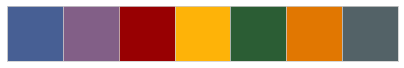

In [280]:
# import custom palette
import my_palette as mp

In [ ]:
# set option for palette argument
# my_palette = ['xkcd:' + c for c in mp.my_colors]

In [110]:
# import dataset
df = pd.read_json('../../data/genres_taglines_ds.json')
df

,genres,tagline
2,"[Crime, Comedy]",Twelve outrageous guests. Four scandalous requ...
3,"[Action, Thriller, Crime]",Don't move. Don't whisper. Don't even breathe.
4,[Documentary],A Megacities remix.
6,"[Adventure, Action, Science Fiction]","A long time ago in a galaxy far, far away..."
7,"[Animation, Family]",There are 3.7 trillion fish in the ocean. They...
...,...,...
545667,[Documentary],The One and Only June Foray
545704,"[History, Drama]",Vera Komissarzhevskaya
545742,[Comedy],Stop Running You Ass-Hole
545761,"[Comedy, Western, Horror, Music]",Senior Slump never looked so good.


In [111]:
# observe unique combinations of genres
df['genres'].apply(tuple).value_counts()

(Documentary,)                                   6541
(Drama,)                                         6155
(Comedy,)                                        4568
(Horror,)                                        2906
(Music,)                                         1583
                                                 ... 
(Crime, Drama, Mystery, Thriller, Action)           1
(Adventure, Western, Romance)                       1
(Comedy, Crime, Drama, Horror, Thriller)            1
(Science Fiction, Fantasy, Adventure, Action)       1
(Horror, Animation, Family, Music, Comedy)          1
Name: genres, Length: 4806, dtype: int64

In [389]:
# get number of genres in longest genre list
max_genres = df['genres'].apply(lambda x: len(x)).max()
max_genres

9

In [113]:
def remove_nones(lst):
    """Return list without empty string values"""
    new_lst = [char for char in lst if char != '']
    
    return new_lst

In [390]:
def separate_genres(data):
    """Return dataset with genres as features"""
    # pad genres lists to be same length as longest list
    for row in data['genres']:
        while len(row) < max_genres:
            row.append('')    
    # pluck out genres, in order
    for genre in range(max_genres):
        data['genre_' + str(genre + 1)] = data['genres'].apply(lambda x: x[genre])
    # return genres column to original form
    data['genres'] = data['genres'].apply(remove_nones)
    
    return data

In [115]:
# observe new dataset
df = separate_genres(df)
df

,genres,tagline,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9
2,"[Crime, Comedy]",Twelve outrageous guests. Four scandalous requ...,Crime,Comedy,,,,,,,
3,"[Action, Thriller, Crime]",Don't move. Don't whisper. Don't even breathe.,Action,Thriller,Crime,,,,,,
4,[Documentary],A Megacities remix.,Documentary,,,,,,,,
6,"[Adventure, Action, Science Fiction]","A long time ago in a galaxy far, far away...",Adventure,Action,Science Fiction,,,,,,
7,"[Animation, Family]",There are 3.7 trillion fish in the ocean. They...,Animation,Family,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
545667,[Documentary],The One and Only June Foray,Documentary,,,,,,,,
545704,"[History, Drama]",Vera Komissarzhevskaya,History,Drama,,,,,,,
545742,[Comedy],Stop Running You Ass-Hole,Comedy,,,,,,,,
545761,"[Comedy, Western, Horror, Music]",Senior Slump never looked so good.,Comedy,Western,Horror,Music,,,,,


In [116]:
# get count of primary genres
df['genre_1'].value_counts()

Drama              13762
Comedy             10846
Documentary         7916
Action              6039
Horror              5853
Thriller            3130
Crime               2390
Music               2379
Romance             2006
Adventure           1902
Western             1684
Animation           1595
Science Fiction     1343
Family               968
Fantasy              865
Mystery              844
TV Movie             425
War                  419
History              344
Name: genre_1, dtype: int64

In [117]:
# get number of genres
num_genres = len(df['genre_1'].value_counts())
num_genres

19

In [13]:
#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel
#from gensim.corpora.dictionary import Dictionary
#from gensim.models.ldamulticore import LdaMulticore

import spacy
#from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

#from tqdm.notebook import tqdm
#from tqdm import tqdm
#from pprint import pprint

import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [12]:
# load language library
nlp = spacy.load('en_core_web_lg')

In [14]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

In [15]:
# instantiate text-processing pipeline
parser = English()

In [16]:
def get_tokens(tagline):
    """Returns tokenized taglines"""
    # 
    tokens = parser(tagline)
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    tokens = [word for word in tokens if word not in stopwords and word not in punctuations]
    tokens = " ".join([i for i in tokens])
    
    return tokens

In [17]:
tagline_tokens = df['tagline'].apply(get_tokens)

In [18]:
tagline_tokens

2         outrageous guests scandalous requests lone bel...
3                                           whisper breathe
4                                          megacities remix
6                     long time ago galaxy far far away ...
7                           3.7 trillion fish ocean looking
                                ...                        
545667                                           june foray
545704                               vera komissarzhevskaya
545742                                stop running ass hole
545761                             senior slump looked good
545797                                       bipolar living
Name: tagline, Length: 64710, dtype: object

In [19]:
cv = CountVectorizer(max_df=0.95, min_df=5)
dtm = cv.fit_transform(tagline_tokens)

In [20]:
dtm

<64710x6777 sparse matrix of type '<class 'numpy.int64'>'
	with 233704 stored elements in Compressed Sparse Row format>

In [21]:
lda = LatentDirichletAllocation(n_components=num_genres, random_state=27)

In [22]:
%%time
lda.fit(dtm)

CPU times: user 1min 10s, sys: 16.9 ms, total: 1min 10s
Wall time: 1min 10s


LatentDirichletAllocation(n_components=19, random_state=27)

In [24]:
for topic, word_probs in enumerate(lda.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{topic}')
    print([cv.get_feature_names()[i] for i in word_probs.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['business', 'trouble', 'vengeance', 'american', 'trust', 'friend', 'animation', 'small', 'crime', 'dream', 'town', 'short', 'comes', 'big', 'film']


THE TOP 15 WORDS FOR TOPIC #1
['begin', 'worst', '000', 'rise', 'getting', 'summer', 'easy', 'freedom', 'lies', 'law', 'nightmare', 'hard', 'going', 'let', 'great']


THE TOP 15 WORDS FOR TOPIC #2
['eyes', 'forget', 'loves', 'world', 'ready', 'justice', 'murder', 'change', 'mind', 'save', 'power', 'future', 'past', 'kill', 'truth']


THE TOP 15 WORDS FOR TOPIC #3
['choose', 'enemy', 'found', 'looking', 'lose', 'beginning', 'welcome', 'face', 'secrets', 'deadly', 'end', 'game', 'hell', 'evil', 'family']


THE TOP 15 WORDS FOR TOPIC #4
['action', 'obsession', 'mad', 'romantic', 'tell', 'changed', 'musical', 'art', 'romance', 'forever', 'screen', 'history', 'lives', 'terror', 'comedy']


THE TOP 15 WORDS FOR TOPIC #5
['guns', 'red', 'thrill', 'action', 'drama', 'born', 'ride', 'dangerous', 'rock', 'hot', 'legen

In [25]:
dtm.shape

(64710, 6777)

In [26]:
len(tagline_tokens)

64710

In [27]:
genre_results = lda.transform(dtm)

In [28]:
genre_results.shape

(64710, 19)

In [118]:
# add LDA topics to data
df['lda_genre'] = genre_results.argmax(axis=1)
col_lst = df.columns.tolist()
moved_col =  col_lst.pop()
col_lst.insert(2, moved_col)
df = df[col_lst]
df

,genres,tagline,lda_genre,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9
2,"[Crime, Comedy]",Twelve outrageous guests. Four scandalous requ...,4,Crime,Comedy,,,,,,,
3,"[Action, Thriller, Crime]",Don't move. Don't whisper. Don't even breathe.,18,Action,Thriller,Crime,,,,,,
4,[Documentary],A Megacities remix.,0,Documentary,,,,,,,,
6,"[Adventure, Action, Science Fiction]","A long time ago in a galaxy far, far away...",18,Adventure,Action,Science Fiction,,,,,,
7,"[Animation, Family]",There are 3.7 trillion fish in the ocean. They...,3,Animation,Family,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
545667,[Documentary],The One and Only June Foray,16,Documentary,,,,,,,,
545704,"[History, Drama]",Vera Komissarzhevskaya,5,History,Drama,,,,,,,
545742,[Comedy],Stop Running You Ass-Hole,3,Comedy,,,,,,,,
545761,"[Comedy, Western, Horror, Music]",Senior Slump never looked so good.,16,Comedy,Western,Horror,Music,,,,,


In [276]:
def get_genre_dist(data):
    """Return distribution of genre labels sorted by LDA genre topics"""
    # Create DataFrame with true distribution of genre labels
    dist_df = pd.DataFrame(
        df.drop(
            ['tagline', 'lda_genre', 'genres'], axis=1).apply(
            pd.Series.value_counts, normalize=True).sum(
            axis=1).sort_values(
            ascending=False)[1:])
    # make list of columns to leave out
    dropped_cols_lst = ['tagline', 'lda_genre', 'genres']
    # iterate through topics
    for topic in range(num_genres):
        # add topic distribution to data
        dist_df = pd.concat(
            [dist_df, 
             data[data['lda_genre'] == topic].drop(
                 dropped_cols_lst, axis=1).apply(
                 pd.Series.value_counts, normalize=True).sum(
                 axis=1).sort_values(
                 ascending=False)[1:]
            ], 
            axis=1, ignore_index=True)
    # create empty list for column names
    topic_names = []
    # iterate through topics
    for topic in range(num_genres):
        # add topic name to list
        topic_names.append('topic_' + str(topic + 1))
    # add column name of true distribution
    topic_names.insert(0, 'true_dist')
    # name DataFrame columns
    dist_df.columns = topic_names
        
    return dist_df

In [278]:
# create genre distribution by topic DataFrame
topics_df = get_genre_dist(df)
topics_df

,true_dist,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
Drama,0.362262,0.354610,0.360251,0.363793,0.342857,0.323636,0.285114,0.350571,0.305783,0.470949,0.390695,0.309591,0.420260,0.373385,0.439748,0.311804,0.420193,0.340077,0.356567,0.342784
Comedy,0.250518,0.277938,0.251653,0.193068,0.222917,0.346061,0.192677,0.276609,0.323948,0.265401,0.192365,0.235239,0.265991,0.253553,0.202153,0.214763,0.246863,0.249033,0.292675,0.253265
Thriller,0.161242,0.129576,0.184476,0.224864,0.233333,0.133939,0.135954,0.188214,0.162882,0.129051,0.205189,0.160262,0.152243,0.184432,0.117091,0.142857,0.152903,0.172270,0.161020,0.115642
Horror,0.144707,0.117500,0.163940,0.157834,0.227381,0.137879,0.120048,0.207156,0.209507,0.098686,0.138682,0.142143,0.123300,0.166021,0.083749,0.147630,0.115845,0.144600,0.160697,0.116916
Action,0.139901,0.113283,0.136791,0.169865,0.165774,0.106364,0.191477,0.129886,0.129276,0.102774,0.211452,0.133708,0.124168,0.146318,0.125492,0.160993,0.133936,0.122583,0.136496,0.134438
Documentary,0.137506,0.155070,0.164984,0.137783,0.099702,0.128485,0.099640,0.104630,0.116863,0.115620,0.109454,0.226179,0.141245,0.114018,0.197165,0.188991,0.109717,0.114252,0.121329,0.159286
Romance,0.120584,0.093732,0.116255,0.101404,0.095833,0.179697,0.099940,0.114251,0.095368,0.236496,0.096630,0.090597,0.138929,0.133075,0.136256,0.104677,0.143566,0.094317,0.117780,0.109908
Crime,0.090110,0.083765,0.109293,0.099971,0.102679,0.072727,0.102941,0.096813,0.073569,0.091095,0.104086,0.086223,0.077279,0.107558,0.087162,0.067770,0.114969,0.096697,0.082930,0.057343
Adventure,0.069587,0.049645,0.060216,0.069321,0.070238,0.066061,0.103842,0.059531,0.065698,0.057518,0.090367,0.068104,0.061071,0.065568,0.080336,0.082724,0.065071,0.050580,0.064860,0.102580
Science Fiction,0.066605,0.051371,0.062652,0.117158,0.085417,0.058182,0.053721,0.061936,0.079322,0.045839,0.074858,0.065292,0.053546,0.045866,0.056445,0.131085,0.048147,0.043439,0.060665,0.081873


In [370]:
# pair each genre label with topic that holds largest proportion of that genre
topics_df.idxmax(axis=1).sort_values()

Animation           topic_1
Action             topic_10
War                topic_10
Documentary        topic_11
History            topic_14
Science Fiction    topic_15
Crime              topic_16
Music              topic_17
Fantasy            topic_19
Family             topic_19
TV Movie            topic_2
Mystery             topic_3
Horror              topic_4
Thriller            topic_4
Comedy              topic_5
Western             topic_6
Adventure           topic_6
Romance             topic_9
Drama               topic_9
dtype: object

In [378]:
topics_df.apply(lambda x: x / topics_df['true_dist'])

,true_dist,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
Drama,1.0,0.978876,0.994447,1.004224,0.946433,0.893376,0.787037,0.967727,0.844092,1.300021,1.078486,0.854604,1.160100,1.030703,1.213893,0.860713,1.159912,0.938760,0.984277,0.946232
Comedy,1.0,1.109453,1.004533,0.770676,0.889824,1.381382,0.769116,1.104148,1.293114,1.059412,0.767870,0.939011,1.061767,1.012116,0.806940,0.857277,0.985412,0.994074,1.168281,1.010968
Thriller,1.0,0.803612,1.144092,1.394570,1.447096,0.830671,0.843167,1.167274,1.010170,0.800354,1.272552,0.993922,0.944188,1.143815,0.726180,0.885977,0.948283,1.068392,0.998618,0.717193
Horror,1.0,0.811988,1.132910,1.090716,1.571318,0.952813,0.829593,1.431551,1.447796,0.681971,0.958362,0.982281,0.852063,1.147287,0.578748,1.020196,0.800546,0.999258,1.110498,0.807950
Action,1.0,0.809740,0.977768,1.214182,1.184936,0.760277,1.368657,0.928411,0.924056,0.734617,1.511442,0.955734,0.887540,1.045866,0.897007,1.150761,0.957365,0.876209,0.975658,0.960948
Documentary,1.0,1.127734,1.199836,1.002015,0.725078,0.934396,0.724623,0.760915,0.849880,0.840840,0.795997,1.644871,1.027190,0.829188,1.433864,1.374425,0.797908,0.830887,0.882359,1.158398
Romance,1.0,0.777316,0.964097,0.840937,0.794742,1.490221,0.828799,0.947482,0.790882,1.961256,0.801348,0.751315,1.152134,1.103586,1.129968,0.868083,1.190586,0.782169,0.976745,0.911460
Crime,1.0,0.929585,1.212893,1.109440,1.139484,0.807097,1.142398,1.074390,0.816443,1.010933,1.155102,0.956867,0.857613,1.193635,0.967287,0.752079,1.275882,1.073107,0.920322,0.636370
Adventure,1.0,0.713425,0.865326,0.996173,1.009351,0.949319,1.492246,0.855485,0.944106,0.826561,1.298609,0.978679,0.877615,0.942247,1.154463,1.188772,0.935105,0.726858,0.932060,1.474124
Science Fiction,1.0,0.771273,0.940656,1.759007,1.282439,0.873537,0.806570,0.929906,1.190932,0.688229,1.123917,0.980290,0.803929,0.688623,0.847465,1.968099,0.722876,0.652197,0.910815,1.229238


In [376]:
topics_df.apply(lambda x: x / topics_df['true_dist']).idxmax(axis=1).sort_values()

Animation           topic_1
Action             topic_10
War                topic_10
Documentary        topic_11
History            topic_14
Science Fiction    topic_15
Crime              topic_16
Music              topic_17
Fantasy            topic_19
Family             topic_19
TV Movie            topic_2
Mystery             topic_3
Horror              topic_4
Thriller            topic_4
Comedy              topic_5
Western             topic_6
Adventure           topic_6
Romance             topic_9
Drama               topic_9
dtype: object

In [386]:
topics_df.apply(lambda x: x / topics_df['true_dist']).T.idxmax(axis=1).sort_values()

topic_1            Animation
topic_2                Crime
topic_13               Crime
topic_11         Documentary
true_dist              Drama
topic_12               Drama
topic_18              Family
topic_19              Family
topic_14             History
topic_8               Horror
topic_4               Horror
topic_7               Horror
topic_16               Music
topic_17               Music
topic_5              Romance
topic_9              Romance
topic_3      Science Fiction
topic_15     Science Fiction
topic_10                 War
topic_6              Western
dtype: object

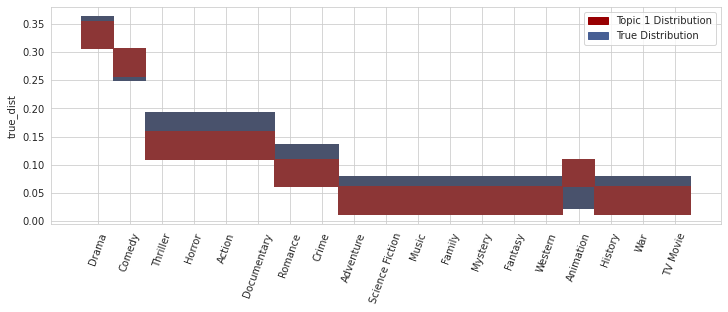

In [355]:
sns.histplot(topics_df, y='true_dist', x=topics_df.index, color=mp.colors(0))
sns.histplot(topics_df, y='topic_1', x=topics_df.index, color=mp.colors(2))
plt.xticks(rotation=70)

red_patch = mpatches.Patch(color=mp.colors(2), label='Topic 1 Distribution')
blue_patch = mpatches.Patch(color=mp.colors(0), label='True Distribution')

plt.legend(handles=[red_patch, blue_patch]);

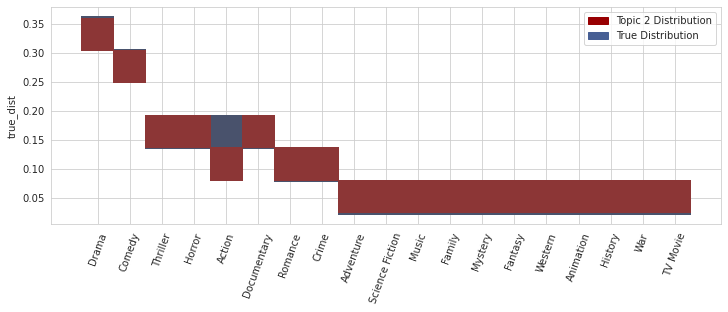

In [356]:
sns.histplot(topics_df, y='true_dist', x=topics_df.index, color=mp.colors(0))
sns.histplot(topics_df, y='topic_2', x=topics_df.index, color=mp.colors(2))
plt.xticks(rotation=70)

red_patch = mpatches.Patch(color=mp.colors(2), label='Topic 2 Distribution')
blue_patch = mpatches.Patch(color=mp.colors(0), label='True Distribution')

plt.legend(handles=[red_patch, blue_patch]);

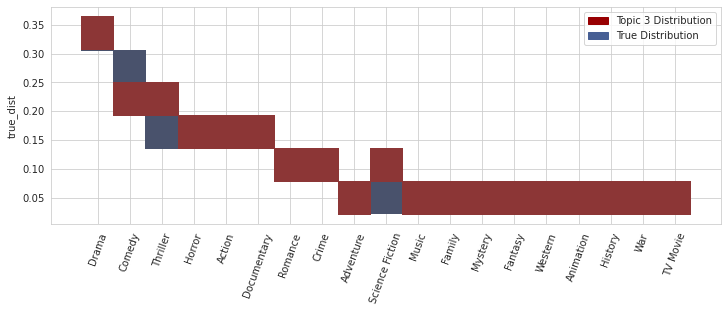

In [357]:
sns.histplot(topics_df, y='true_dist', x=topics_df.index, color=mp.colors(0))
sns.histplot(topics_df, y='topic_3', x=topics_df.index, color=mp.colors(2))
plt.xticks(rotation=70)

red_patch = mpatches.Patch(color=mp.colors(2), label='Topic 3 Distribution')
blue_patch = mpatches.Patch(color=mp.colors(0), label='True Distribution')

plt.legend(handles=[red_patch, blue_patch]);

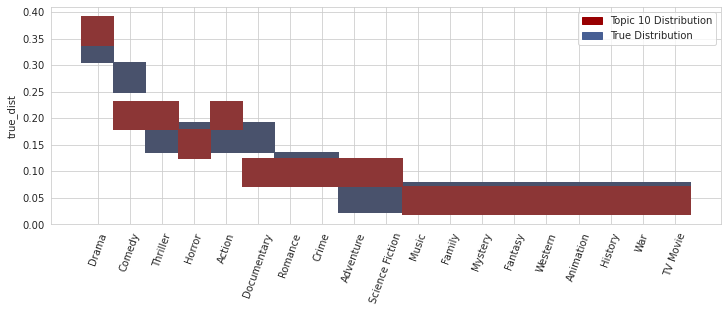

In [388]:
sns.histplot(topics_df, y='true_dist', x=topics_df.index, color=mp.colors(0))
sns.histplot(topics_df, y='topic_10', x=topics_df.index, color=mp.colors(2))
plt.xticks(rotation=70)

red_patch = mpatches.Patch(color=mp.colors(2), label='Topic 10 Distribution')
blue_patch = mpatches.Patch(color=mp.colors(0), label='True Distribution')

plt.legend(handles=[red_patch, blue_patch]);

In [31]:
taglines = [tagline for tagline in tagline_tokens]
taglines[:10]

['outrageous guests scandalous requests lone bellhop day job wildest new year eve life',
 'whisper breathe',
 'megacities remix',
 'long time ago galaxy far far away ...',
 '3.7 trillion fish ocean looking',
 'life like box chocolates ... know',
 'look closer',
 'terrific',
 'need eyes',
 'living dead']

In [32]:
doc = nlp(taglines)

TypeError: Argument 'string' has incorrect type (expected str, got list)

In [17]:
word_dict = Dictionary(taglines)

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [14]:
# show default stop words
print(nlp.Defaults.stop_words)

{'everywhere', 'your', 'front', 'keep', '’ve', 'us', 'ca', 'four', 'its', 'off', 'please', '‘d', 'next', 'can', 'namely', 'therein', 'others', 'another', 'whenever', 'move', 'any', 'mostly', 'few', 'in', 'other', 'those', 'it', 'when', 'bottom', 'then', 'show', 'latter', 'thru', 'towards', 'get', 'becoming', 'against', 'just', 'whence', 'hence', 'done', 'first', 'various', 'along', 'least', 'above', "'m", 'beyond', 'see', 'is', 'too', 'also', 'onto', 'yours', 'therefore', 'did', 'sixty', 'made', 'are', 'nevertheless', 'over', 'my', 'every', 'go', '’re', 'seeming', 'nine', 'either', 'their', 'while', 'them', 'top', 'used', 'own', 'or', 'eight', 'anyone', 'me', 'do', 'had', 'more', "'ll", 'thereby', 'twelve', 'once', 'during', 'by', 'six', 'even', 'may', 'only', 'perhaps', 'really', 'why', 'he', 'via', 'which', 'back', 'fifty', 'put', 'moreover', 'something', 'has', 'say', 'afterwards', 'three', 'anyhow', 'toward', 'call', 'somehow', 'make', 'full', 'himself', 'should', 'whom', 'within',